## IR Analysis of Personas

In [23]:
import pandas as pd
persona_queries = pd.read_csv("drive/MyDrive/ChatGPT/4_personas_topics_1-50.csv")

persona_queries = persona_queries.drop("Unnamed: 0", axis = 1).rename(columns = {"index": "qno", "persona": "user", "topic": "qid", "queries": "query"})
persona_queries = persona_queries[["qno", "user", "qid", "query"]]
uqv = persona_queries
uqv

,qno,user,qid,query
0,1,edith,1,radio waves
1,2,edith,1,brain cancer
2,3,edith,1,incidence brain cancer general population
3,4,edith,1,incidence brain cancer radio towers
4,5,edith,1,incidence brain cancer mobile phones
...,...,...,...,...
1921,6,markus,49,college attendance benefits
1922,7,markus,49,college education job prospects
1923,8,markus,49,college degree advantages
1924,9,markus,49,college education income impact


In [ ]:
!pip install python-terrier

In [ ]:
!pip install ranx

In [ ]:
!pip install repro-eval

In [ ]:
!wget https://th-koeln.sciebo.de/s/Agvx4PoLN3oCkZh/download -O ./drive/MyDrive/ChatGPT/index.tar.xz

In [7]:
!tar -xf ./drive/MyDrive/ChatGPT/index.tar.xz -C ./drive/MyDrive/ChatGPT/

In [24]:
import os
# valid for google colab
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

import pyterrier as pt
if not pt.started():
    pt.init()
    

from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion
    
dataset = pt.get_dataset('irds:nyt/trec-core-2017')

#needs to be adjusted to own system
index_ref = pt.IndexRef.of("./drive/MyDrive/ChatGPT/index/nyt")#('./index/nyt') 

qrels = Qrels.from_ir_datasets("nyt/trec-core-2017")

Replacing the qid with the correct one matching the qrels data. 

In [25]:
look_up_ids = dataset.get_topics()["qid"].reset_index().rename(columns = {"index":"topic"})
look_up_ids["topic"] = look_up_ids["topic"]

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


Also replacing special characters within the persona queries, otherwise the following error occurs:

```
JavaException: JVM exception occurred: Failed to process qid 423 'Milosevic's wife nickname' -- Lexical error at line 1, column 10.  Encountered: "\'" (39), after : "" org.terrier.querying.parser.QueryParserException
```

In [26]:
uqv = uqv.merge(look_up_ids, how = "left", left_on = "qid", right_on = "topic").rename(columns = {"qid_y": "qid"}).drop(labels = ["qid_x", "topic"], axis = "columns")
uqv = uqv[["qno", "user", "qid", "query"]]
uqv["query"] = uqv["query"].replace(to_replace = "'", value = "", regex = True)
uqv

,qno,user,qid,query
0,1,edith,310,radio waves
1,2,edith,310,brain cancer
2,3,edith,310,incidence brain cancer general population
3,4,edith,310,incidence brain cancer radio towers
4,5,edith,310,incidence brain cancer mobile phones
...,...,...,...,...
1921,6,markus,690,college attendance benefits
1922,7,markus,690,college education job prospects
1923,8,markus,690,college degree advantages
1924,9,markus,690,college education income impact


The dataset contains more topics than we are currently take into account, therefore we need to slice the dataset to match our topics.

In [27]:
list_qid_personas = uqv["qid"].unique().tolist()
dataset_sliced = dataset.get_topics('title')[dataset.get_topics('title')["qid"].isin(list_qid_personas)]

For some topics, less than 10 queries were produced, they need to be removed from the datasets, otherwise compiling the results is not working

In [28]:
qid_to_remove = []

for i in list_qid_personas:
  for name in uqv["user"].unique():
    if uqv[(uqv["user"] == name) & (uqv["qid"] == i)].shape[0] == 10:
      pass
    else:
      qid_to_remove.append(i)
      print(name, i)

qid_to_remove = set(qid_to_remove)
print(qid_to_remove)

dataset_sliced_revised = dataset_sliced[~dataset_sliced["qid"].isin(qid_to_remove)]
uqv_revised = uqv[~uqv["qid"].isin(qid_to_remove)]

john 400
edith 416
john 416
karen 416
markus 416
edith 677
john 677
{'677', '416', '400'}


In [29]:
bm25 = pt.BatchRetrieve(index_ref, wmodel='BM25')
# slicing of dataset needs to be adjusted depending on the persona queries
baseline = bm25(dataset_sliced_revised)
pt.io.write_results(baseline, 'baseline', format='trec', append=False)
baseline_ranx = Run.from_file('baseline', kind='trec')
baseline_ranx.name = 'BM25'

In [30]:
run_dict = {}

for name in ['edith', 'john', 'karen', 'markus']:

  runs = []

  for i in range(1, 11):

    queries = uqv_revised[(uqv_revised['user'] == name) & (uqv_revised['qno']==i)][['qid', 'query']]

    pt.io.write_results(bm25(queries), 'bm25_'+name, format='trec', append=False)
    runs.append(Run.from_file('bm25_'+name, kind='trec'))

  run_dict[name] = runs

In [31]:
edith_ranx = Run.from_file('bm25_edith', kind='trec')
edith_ranx.name = 'Edith'

john_ranx = Run.from_file('bm25_john', kind='trec')
john_ranx.name = 'John'

karen_ranx = Run.from_file('bm25_karen', kind='trec')
karen_ranx.name = 'Karen'

markus_ranx = Run.from_file('bm25_markus', kind='trec')
markus_ranx.name = 'Markus'

It only works if they have the same ids and also the same number. So if only working with partly results for personas, the qrels must be sliced to the same sample.

In [32]:
import ir_datasets
qrels_dataset = ir_datasets.load("nyt/trec-core-2017").qrels_dict()

qrels_dataset_sub = {}
for id in edith_ranx.get_query_ids():
  qrels_dataset_sub[id] = qrels_dataset[id]

In [52]:
report = compare(
    qrels=Qrels.from_dict(qrels_dataset_sub),
    runs=[baseline_ranx, edith_ranx, john_ranx, karen_ranx, markus_ranx],
    metrics=["ndcg", "map", "precision@10", "bpref","f1"],
    max_p=0.05  
)

report

#    Model    NDCG       MAP        P@10      BPref    F1
---  -------  ---------  ---------  --------  -------  ---------
a    BM25     0.414ᵇᶜᵈᵉ  0.184ᵇᶜᵈᵉ  0.454ᶜᵈᵉ  0.261ᶜᵉ  0.133ᵇᶜᵈᵉ
b    Edith    0.325      0.131      0.376     0.239    0.044
c    John     0.318      0.118      0.317     0.222    0.041
d    Karen    0.317      0.122      0.307     0.230    0.027
e    Markus   0.293      0.112      0.304     0.213    0.036

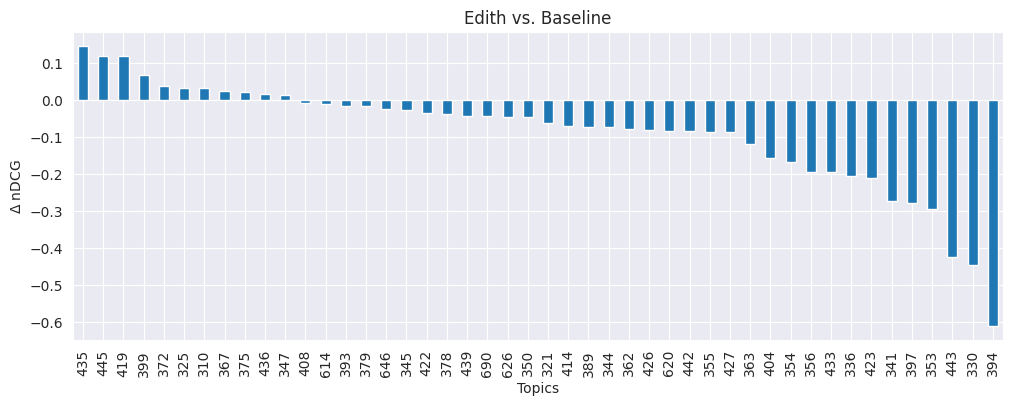

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

delta = pd.DataFrame.from_dict(edith_ranx.scores) - pd.DataFrame.from_dict(baseline_ranx.scores) 
ax = delta['ndcg'].sort_values(ascending=False).plot(figsize=(12,4), kind='bar')
ax.set_xlabel("Topics")
ax.set_ylabel('$\Delta$ nDCG')
plt.title("Edith vs. Baseline")
plt.show()

In [53]:
results_df = pd.DataFrame()

for name in ['edith', 'john', 'karen', 'markus']:
  df_temp_1 = pd.DataFrame.from_dict(eval(name + "_ranx.scores")) - pd.DataFrame.from_dict(baseline_ranx.scores)
  df_temp_1 = df_temp_1.reset_index(names = "qid")
  df_temp_2 = pd.DataFrame({"name": [name]})

  df_temp = df_temp_1.join(df_temp_2, how = "cross")
  results_df = pd.concat([results_df, df_temp], axis = "index")

results_df

,qid,ndcg,map,precision@10,bpref,f1,name
0,310,0.032594,0.024633,0.3,0.002310,-0.000159,edith
1,321,-0.062458,-0.085266,0.0,-0.006780,-0.002991,edith
2,325,0.032756,0.038799,0.2,0.083260,0.024689,edith
3,330,-0.446091,-0.078958,-0.2,-0.097382,-0.148488,edith
4,336,-0.205252,-0.246066,-0.3,-0.057751,-0.111646,edith
...,...,...,...,...,...,...,...
41,614,-0.439499,-0.413801,-0.9,-0.435367,-0.058435,markus
42,620,-0.102601,-0.211946,-0.4,-0.131344,-0.097235,markus
43,626,-0.250607,-0.190734,-0.3,-0.065443,-0.200000,markus
44,646,-0.050618,0.021424,0.0,0.090679,-0.309091,markus


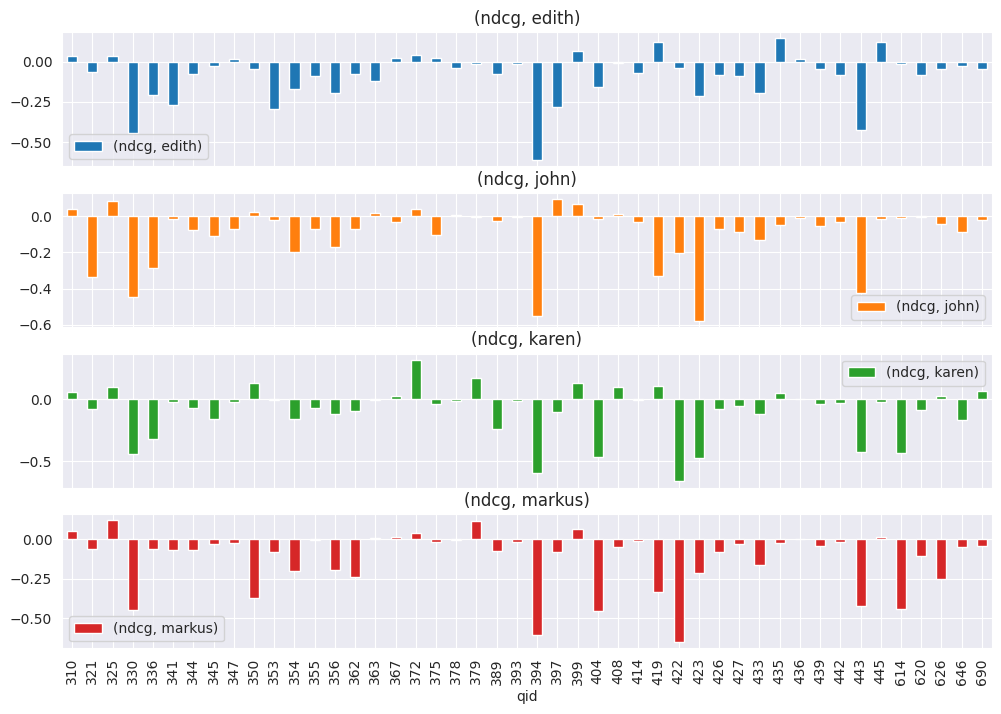

In [72]:
ax = results_df[["qid","ndcg","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,8), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
#plt.setp(ax, ylim = (-1,0.5))
plt.show()

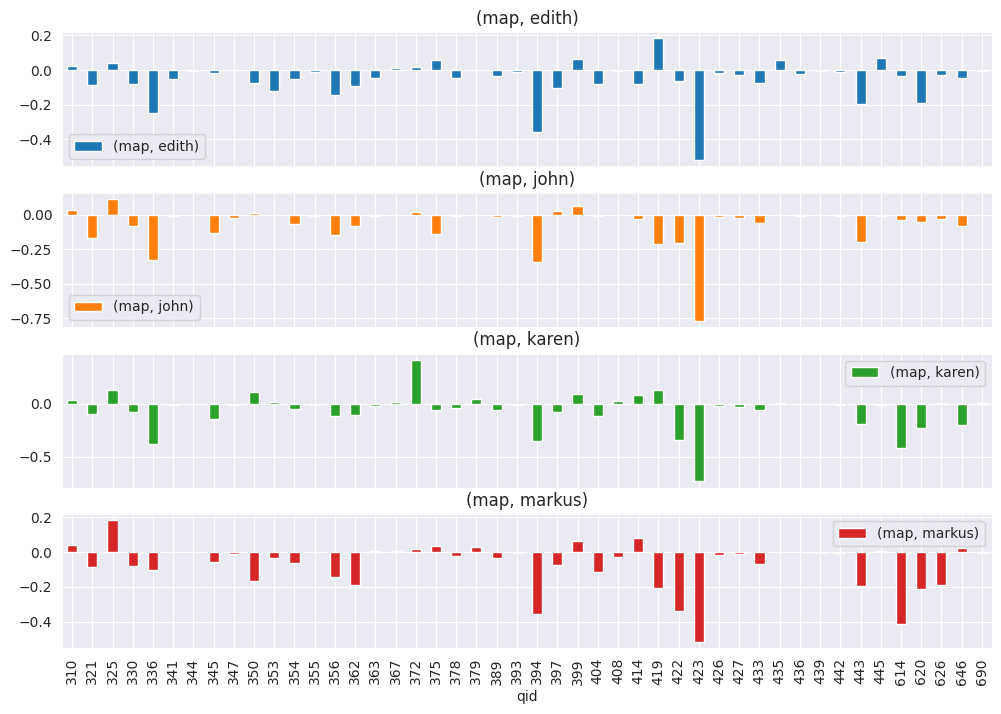

In [73]:
ax = results_df[["qid","map","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,8), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
#plt.setp(ax, ylim = (-1,0.5))
plt.show()

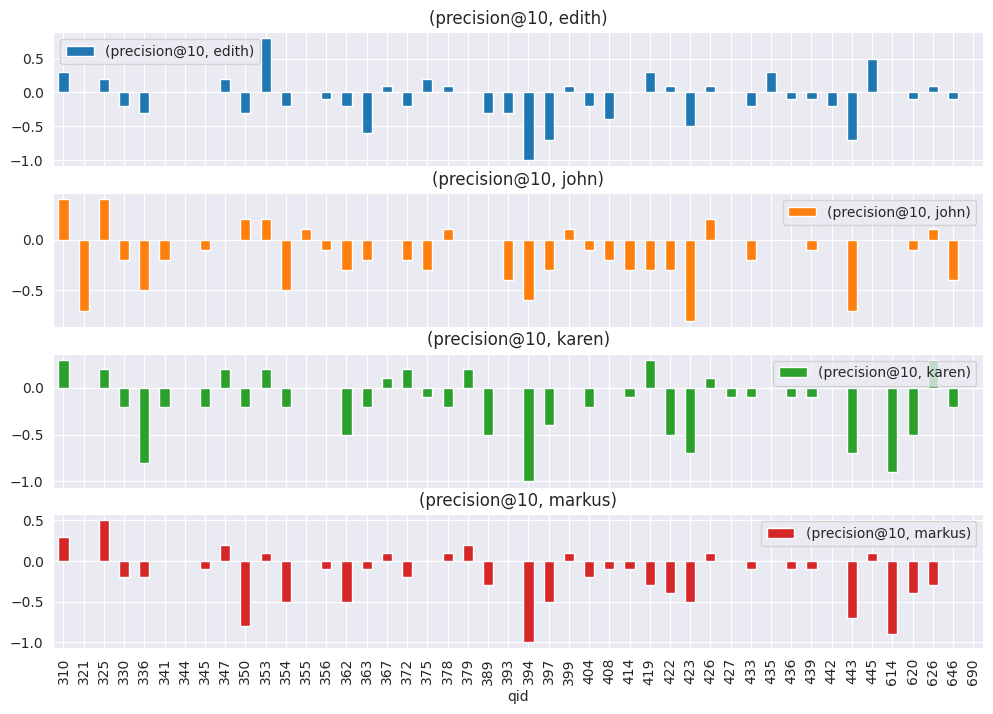

In [74]:
ax = results_df[["qid","precision@10","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,8), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
#plt.setp(ax, ylim = (-1,0.5))
plt.show()

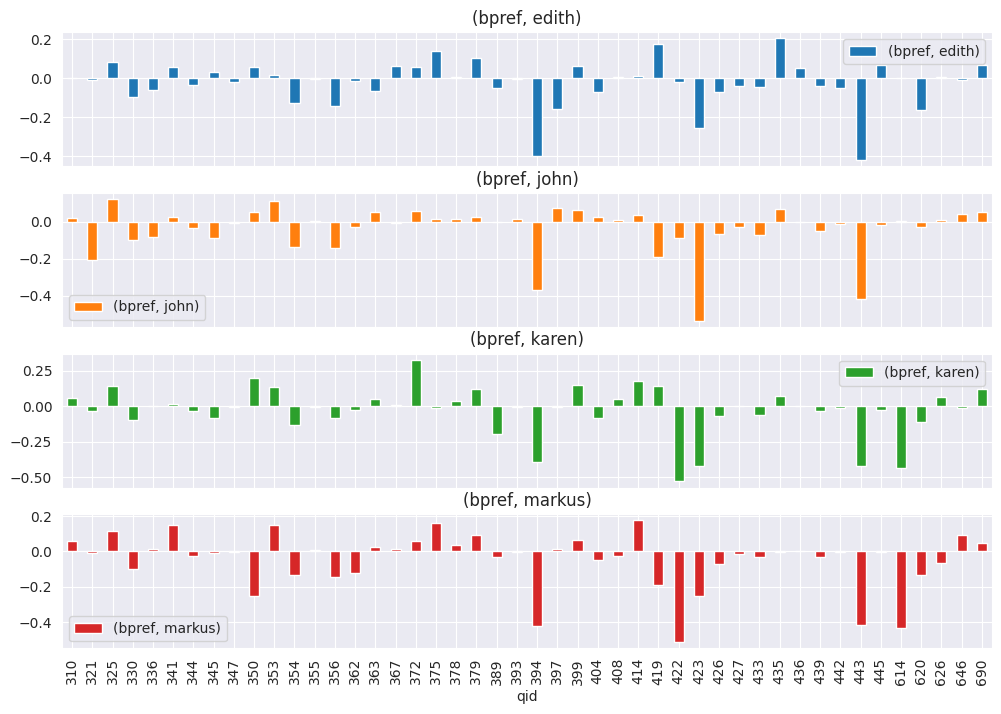

In [75]:
ax = results_df[["qid","bpref","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,8), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
#plt.setp(ax, ylim = (-1,0.5))
plt.show()

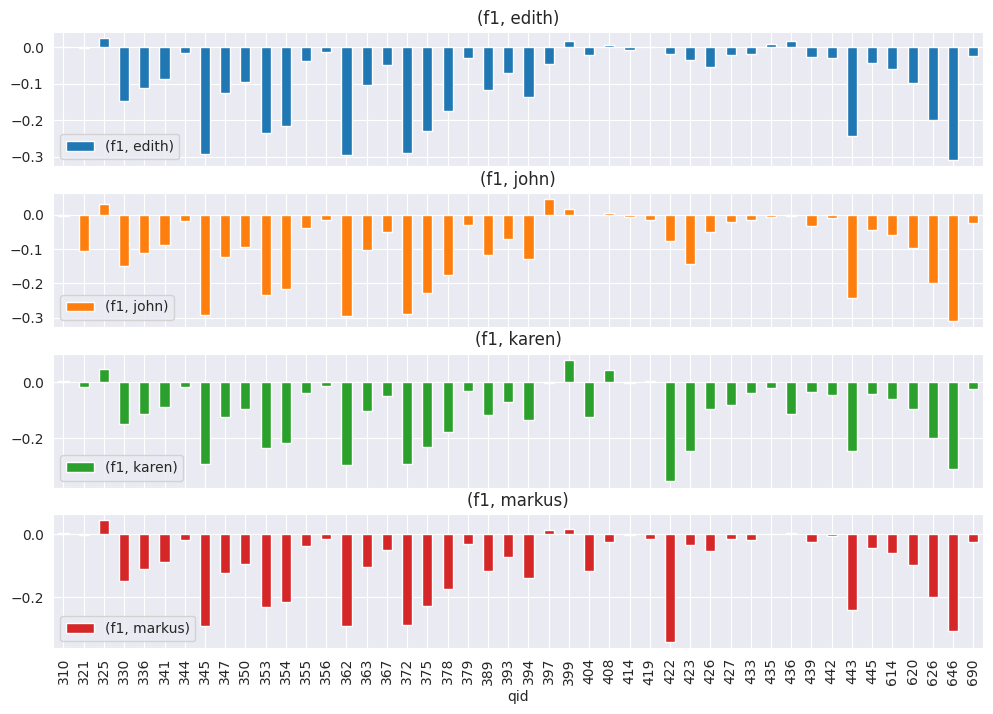

In [76]:
ax = results_df[["qid","f1","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,8), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
#plt.setp(ax, ylim = (-1,0.5))
plt.show()

In [ ]:
dataset.get_topics()

In [96]:
for metric in ['ndcg', 'map', 'precision@10','bpref', 'f1']:
  for name in ['edith', 'john', 'karen', 'markus']:
    df_temp_1 = pd.DataFrame.from_dict(eval(name + "_ranx.scores")) - pd.DataFrame.from_dict(baseline_ranx.scores)
    df_temp_1 = df_temp_1.reset_index(names = "qid")
    df_temp_2 = pd.DataFrame({"name": [name]})
    df_temp = df_temp_1.join(df_temp_2, how = "cross")
    temp = df_temp['bpref'].to_list()
    neg_count = len(list(filter(lambda x: (x < 0), temp)))
    percentage_worse = round((neg_count/len(temp)*100),2)
    print("%s queries are worse than the baselines at %s in %s percent of cases." % (name,metric,percentage_worse))

edith queries are worse than the baselines at ndcg in 54.35 percent of cases.
john queries are worse than the baselines at ndcg in 50.0 percent of cases.
karen queries are worse than the baselines at ndcg in 56.52 percent of cases.
markus queries are worse than the baselines at ndcg in 60.87 percent of cases.
edith queries are worse than the baselines at map in 54.35 percent of cases.
john queries are worse than the baselines at map in 50.0 percent of cases.
karen queries are worse than the baselines at map in 56.52 percent of cases.
markus queries are worse than the baselines at map in 60.87 percent of cases.
edith queries are worse than the baselines at precision@10 in 54.35 percent of cases.
john queries are worse than the baselines at precision@10 in 50.0 percent of cases.
karen queries are worse than the baselines at precision@10 in 56.52 percent of cases.
markus queries are worse than the baselines at precision@10 in 60.87 percent of cases.
edith queries are worse than the baseli

In [114]:
comparisons = pd.DataFrame()
for metric in ['ndcg', 'map', 'precision@10','bpref', 'f1']:
  temp_list = []
  temp2 = []
  for name in ['edith', 'john', 'karen', 'markus']:
    df_temp_1 = pd.DataFrame.from_dict(eval(name + "_ranx.scores")) - pd.DataFrame.from_dict(baseline_ranx.scores)
    df_temp_1 = df_temp_1.reset_index(names = "qid")
    df_temp_2 = pd.DataFrame({"name": [name]})
    df_temp = df_temp_1.join(df_temp_2, how = "cross")
    temp = df_temp[metric].to_list()
    temp2.append(df_temp[metric].mean())
    neg_count = len(list(filter(lambda x: (x < 0), temp)))
    temp_list.append(round((neg_count/len(temp)*100),2))
  comparisons[metric] = temp_list
  aver = metric + '_mean'
  comparisons[aver] = temp2
comparisons['Personas'] = ['edith', 'john', 'karen', 'markus']
comparisons = comparisons.set_index('Personas')
comparisons
  
    

,ndcg,ndcg_mean,map,map_mean,precision@10,precision@10_mean,bpref,bpref_mean,f1,f1_mean
Personas,,,,,,,,,,
edith,76.09,-0.088927,78.26,-0.053426,47.83,-0.078261,54.35,-0.022389,86.96,-0.088146
john,80.43,-0.096003,84.78,-0.066389,54.35,-0.136957,50.00,-0.039283,91.30,-0.091998
karen,71.74,-0.096695,69.57,-0.061479,54.35,-0.147826,56.52,-0.030935,89.13,-0.105450
markus,80.43,-0.120847,76.09,-0.071662,54.35,-0.150000,60.87,-0.048092,86.96,-0.096217
